In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

In [2]:
nx, ny = 150, 150
N_t = 77
L_left, L_right = 0, 4380
N_point = nx * ny

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
j = 3


def get_dataset(experiment_idx):
    print(f"Processing dataset {j}...")


    U_total = np.zeros((N_point * N_t, 1))
    X_total = np.zeros((N_point * N_t, 1))
    Y_total = np.zeros((N_point * N_t, 1))
    T_total = np.zeros((N_point * N_t, 1))

    # Generate the grid for x, y, and time (t)
    for i in range(N_t):
        x = np.linspace(L_left, L_right, nx)
        y = np.linspace(L_left, L_right, ny)
        X, Y = np.meshgrid(x, y)
        T = np.full((N_point, 1), i * 20)

        # Determine the slice of indices corresponding to time step i
        start_idx = i * N_point
        end_idx = (i + 1) * N_point

        # Reshape X, Y to column vectors and assign
        X_total[start_idx:end_idx, 0] = X.reshape(-1)
        Y_total[start_idx:end_idx, 0] = Y.reshape(-1)
        T_total[start_idx:end_idx, 0] = T.reshape(-1)

    # Define input and output file paths
    input_file = f"./Data/U_total_{j}.mat"
    output_file = f"./MeshData/TriangularMesh/U_xy{j}.mat"
    if j in [1, 2, 5, 6]:
        output_file = f"./MeshData/CircularMesh/U_xy{j}.mat"

    # Load simulation data from the .mat file
    U = sio.loadmat(input_file)
    # Convert to NumPy array, ensuring shape matches (N_point*N_t, 1)
    U_data = np.array(U[f"U_{j}"][: N_point * N_t, 0])[:, None]

    # Combine X, Y, T, and U into a single NumPy array
    U_xy_np = np.hstack([X_total, Y_total, T_total, U_data])

    # Optionally convert to PyTorch tensors
    U_xy_torch = torch.from_numpy(U_xy_np.astype(np.float32))


    return U_xy_torch


In [5]:
from sklearn.model_selection import train_test_split



def preprocess_data(data: torch.Tensor):
    """
    data: A torch.Tensor of shape (N, 4) containing [x, y, t, u].
    This function normalizes each column to [0, 1] range.
    Returns:
        data: normalized in-place
        data_bounds: dictionary of min/max for each column
    """
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()
    t_min, t_max = data[:, 2].min(), data[:, 2].max()
    u_min, u_max = data[:, 3].min(), data[:, 3].max()

    data[:, 0] = (data[:, 0] - x_min) / (x_max - x_min)
    data[:, 1] = (data[:, 1] - y_min) / (y_max - y_min)
    data[:, 2] = (data[:, 2] - t_min) / (t_max - t_min)
    data[:, 3] = (data[:, 3] - u_min) / (u_max - u_min)

    # Store bounds in a dictionary (convert Tensors to float)
    data_bounds = {
        "x_min": x_min.item(),
        "x_max": x_max.item(),
        "y_min": y_min.item(),
        "y_max": y_max.item(),
        "t_min": t_min.item(),
        "t_max": t_max.item(),
        "u_min": u_min.item(),
        "u_max": u_max.item(),
    }

    return data, data_bounds





def invert_normalization(data: torch.Tensor, data_bound: dict, feature: str):
    """
    Invert normalization for a given feature.
    data: a torch.Tensor for the feature, in [0,1] range.
    data_bound: dictionary with min/max values.
    feature: one of 'x', 'y', 't', or 'u'.
    """
    feature_min = data_bound[f"{feature}_min"]
    feature_max = data_bound[f"{feature}_max"]

    return data * (feature_max - feature_min) + feature_min





def split_and_preprocess_dataset(mesh_type: str, j: int):
    """
    1) Loads dataset via get_dataset(j)
    2) Splits into train/test
    3) Normalizes each subset
    4) Returns x_train, x_test, y_train, y_test, ... plus the test_min_max dictionary
    """
    data = get_dataset(j)  # shape (N, 4), presumably on CPU right now

    data = data.to(device)

    # Convert to NumPy for train_test_split (which only works on CPU), then back to Torch
    data_np = data.cpu().numpy()  # move temporarily to CPU for NumPy ops
    train_data_np, test_data_np = train_test_split(
        data_np, test_size=0.2, random_state=42
    )

    # Convert back to torch Tensors on CPU
    train_data_cpu = torch.from_numpy(train_data_np)
    test_data_cpu = torch.from_numpy(test_data_np)

    train_data = train_data_cpu.to(device)
    test_data = test_data_cpu.to(device)

    train_data, _ = preprocess_data(train_data)
    test_data, test_min_max = preprocess_data(test_data)

    x_train, y_train, t_train, u_train = (
        train_data[:, 0],
        train_data[:, 1],
        train_data[:, 2],
        train_data[:, 3],
    )
    x_test, y_test, t_test, u_test = (
        test_data[:, 0],
        test_data[:, 1],
        test_data[:, 2],
        test_data[:, 3],
    )

    # Print shapes
    if mesh_type == "circular":
        print(f"CircularMesh - Training Data Shape: {train_data.shape}")
        print(f"CircularMesh - Testing Data Shape: {test_data.shape}")
    else:
        print(f"TriangularMesh - Training Data Shape: {train_data.shape}")
        print(f"TriangularMesh - Testing Data Shape: {test_data.shape}")

    return (
        x_train,
        x_test,
        y_train,
        y_test,
        t_train,
        t_test,
        u_train,
        u_test,
        test_min_max,
    )


if j in [1, 2, 5, 6]:
    mesh_type = "circular"
else:
    mesh_type = "triangular"

x_train, x_val, y_train, y_val, t_train, t_val, u_train, u_val, test_min_max = (
    split_and_preprocess_dataset(mesh_type, j)
)

x_train = torch.cat(
    (x_train.unsqueeze(1), y_train.unsqueeze(1), t_train.unsqueeze(1)), dim=1
)
y_train = u_train

x_val = torch.cat((x_val.unsqueeze(1), y_val.unsqueeze(1), t_val.unsqueeze(1)), dim=1)
y_val = u_val

Processing dataset 3...
TriangularMesh - Training Data Shape: torch.Size([1386000, 4])
TriangularMesh - Testing Data Shape: torch.Size([346500, 4])


In [6]:
class U_Net(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=1, num_layers=3):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 2):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, xyt):
        return self.net(xyt)


class D_Net(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1, num_layers=3):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 2):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Softplus()) 
        self.net = nn.Sequential(*layers)

    def forward(self, u):
        return self.net(u)


class G_Net(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1, num_layers=3):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 2):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, u):
        return self.net(u)




In [7]:
import numpy as np

def compute_aic_bic(loss, num_params, num_data_points):
    """
    Computes the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).
    
    Args:
        loss (float): Negative log-likelihood or loss value.
        num_params (int): Number of parameters in the model.
        num_data_points (int): Number of data points used.
        
    Returns:
        tuple: AIC, BIC values.
    """
    aic = 2 * num_params + 2 * loss
    bic = num_params * np.log(num_data_points) + 2 * loss
    return aic, bic


In [8]:
def train_binn(u_net, D_net, G_net, train_loader, val_loader, epochs=10):
    optimizer = optim.Adam(
        list(u_net.parameters()) + list(D_net.parameters()) + list(G_net.parameters()),
        lr=1e-3,
    )

    
    train_losses = []
    val_losses = []
    aic_values = []
    bic_values = []

    num_params = sum(p.numel() for p in u_net.parameters()) + \
                 sum(p.numel() for p in D_net.parameters()) + \
                 sum(p.numel() for p in G_net.parameters())
    num_data_points = len(train_loader.dataset)

    for epoch in range(1, epochs + 1):
        u_net.train()
        D_net.train()
        G_net.train()

        train_loss = 0.0
        for x_batch, u_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False):
            x_batch = x_batch.to(device)
            u_batch = u_batch.to(device)
            x_batch = x_batch.requires_grad_(True)
            optimizer.zero_grad()

            u_pred = u_net(x_batch)
            loss_data = torch.mean((u_pred - u_batch) ** 2)

            D = D_net(u_pred)
            G = G_net(u_pred)

            grad_u = torch.autograd.grad(
                u_pred, x_batch, grad_outputs=torch.ones_like(u_pred), create_graph=True
            )[0]
            du_dx, du_dy, du_dt = grad_u[:, 0:1], grad_u[:, 1:2], grad_u[:, 2:3]
            term_x = D * du_dx
            term_y = D * du_dy
            d_term_x = torch.autograd.grad(
                term_x, x_batch, grad_outputs=torch.ones_like(term_x), create_graph=True
            )[0][:, 0:1]
            d_term_y = torch.autograd.grad(
                term_y, x_batch, grad_outputs=torch.ones_like(term_y), create_graph=True
            )[0][:, 1:2]
            pde_residual = du_dt - (d_term_x + d_term_y + G * u_pred)
            loss_pde = torch.mean(pde_residual**2)

            loss_total = loss_data + loss_pde
            loss_total.backward()
            optimizer.step()

            train_loss += loss_total.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = 0.0
        with torch.no_grad():
            for x_val, u_val in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False):
                u_pred = u_net(x_val)
                val_loss += torch.mean((u_pred - u_val) ** 2).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        aic, bic = compute_aic_bic(avg_train_loss, num_params, num_data_points)
        aic_values.append(aic)
        bic_values.append(bic)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | AIC: {aic:.2f} | BIC: {bic:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), aic_values, label="AIC", color="blue")
    plt.plot(range(1, epochs + 1), bic_values, label="BIC", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Criterion Value")
    plt.title("AIC and BIC Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/3 - Training:   0%|          | 0/10829 [00:00<?, ?it/s]c:\Users\parsa\anaconda3\envs\deeplearning\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/3 | Train Loss: 0.0361 | Val Loss: 0.0506 | AIC: 38918.07 | BIC: 275187.94


Epoch 2/3 | Train Loss: 0.0360 | Val Loss: 0.0507 | AIC: 38918.07 | BIC: 275187.94


Epoch 3/3 | Train Loss: 0.0360 | Val Loss: 0.0509 | AIC: 38918.07 | BIC: 275187.94


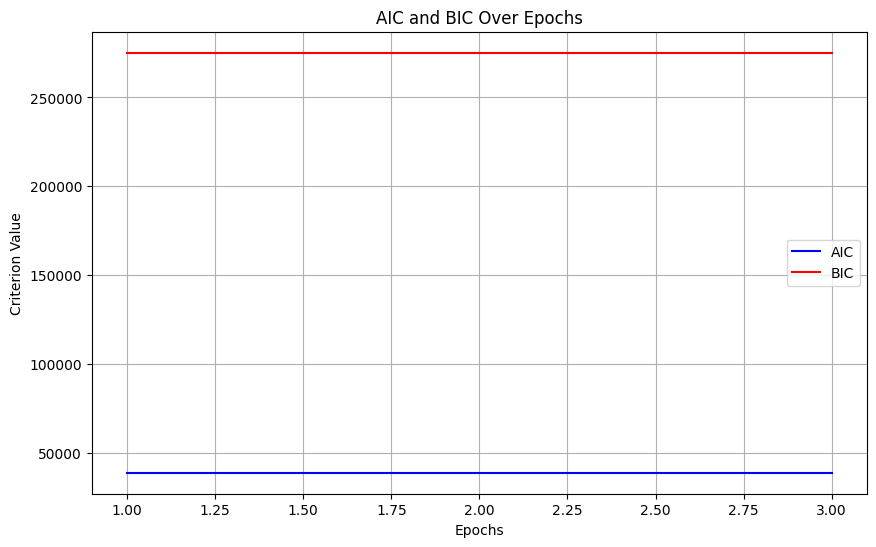

In [ ]:
u_net = U_Net(input_dim=3).to(device)  # 3 input features (x, y, t)
D_net = D_Net(input_dim=1).to(device)  # 1 input feature (u)
G_net = G_Net(input_dim=1).to(device)  # 1 input feature (u)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train_binn(u_net, D_net, G_net, train_loader, val_loader, epochs=3)